# 1. DATA EXPLORATION
- Analyze the 15 power plants: production variance and missing values
- Check correlations between weather variables to identify redundancy

In [ ]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
import shap


In [ ]:
#EXPORTING DATA
train_url = "https://raw.githubusercontent.com/LeHoangViet03/Fintech-CYTech/main/Energy_Production_Train.csv"
test_url  = "https://raw.githubusercontent.com/LeHoangViet03/Fintech-CYTech/main/Energy_Production_Test.csv"

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

print(train.shape, test.shape)

# Define main columns
plant_col = "Plant_ID"
time_col = "UTC Time"
target_col = "Energy_Production"

# Parse timestamps and sort by plant and time for correct panel time ordering
train[time_col] = pd.to_datetime(train[time_col])
test[time_col]  = pd.to_datetime(test[time_col])

train = train.sort_values([plant_col, time_col]).reset_index(drop=True)
test  = test.sort_values([plant_col, time_col]).reset_index(drop=True)

train.head()


(176505, 17) (59376, 17)


,UTC Time,Plant_ID,Energy_Production,Benchmark,Day-Night,Temperature descriptor,Comfort level,Visibility,Probability of precipitation for last hour,Rainfall amount for last hour,Dew point,Temperature,Wind direction,Precipitation descriptor,Sky descriptor,Humidity,Wind speed
0,2020-01-04 00:00:00+00:00,0,0.0,0.0,N,4.0,1.23,17.21,1.0,0.0,0.0,2.5,277.0,0,2.0,84.0,5.04
1,2020-01-04 01:00:00+00:00,0,0.0,0.0,N,4.0,0.28,17.39,1.0,0.0,-0.3,1.8,290.0,0,2.0,86.0,5.40
2,2020-01-04 02:00:00+00:00,0,0.0,0.0,N,4.0,-0.89,18.57,0.0,0.0,-0.7,0.9,297.0,0,2.0,89.0,5.76
3,2020-01-04 03:00:00+00:00,0,0.0,0.0,N,4.0,-1.96,19.75,0.0,0.0,-1.1,0.1,300.0,0,2.0,92.0,6.12
4,2020-01-04 04:00:00+00:00,0,0.0,0.0,N,3.0,-2.30,19.93,0.0,0.0,-1.4,-0.2,299.0,0,2.0,92.0,6.12


In [ ]:
#DATA EXPLORATION
train[plant_col].value_counts()
train.info()
display(train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176505 entries, 0 to 176504
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype              
---  ------                                      --------------   -----              
 0   UTC Time                                    176505 non-null  datetime64[ns, UTC]
 1   Plant_ID                                    176505 non-null  int64              
 2   Energy_Production                           176505 non-null  float64            
 3   Benchmark                                   176505 non-null  float64            
 4   Day-Night                                   176505 non-null  object             
 5   Temperature descriptor                      176505 non-null  float64            
 6   Comfort level                               176505 non-null  float64            
 7   Visibility                                  176505 non-null  float64            
 8   Probability of precipita

,Plant_ID,Energy_Production,Benchmark,Temperature descriptor,Comfort level,Visibility,Probability of precipitation for last hour,Rainfall amount for last hour,Dew point,Temperature,Wind direction,Precipitation descriptor,Sky descriptor,Humidity,Wind speed
count,176505.000000,176505.000000,176505.00000,176505.000000,176505.000000,176505.000000,176505.000000,176505.000000,176505.000000,176505.000000,176505.000000,1.765050e+05,176505.000000,176505.000000,176505.000000
mean,7.731056,0.009563,0.00952,6.219943,12.226085,19.013074,12.133951,0.010837,6.998382,12.731229,140.857568,-4.380011e+06,9.754715,71.130178,7.590162
std,4.562745,0.015391,0.01537,2.003239,9.615682,8.684866,18.425581,0.041445,6.926009,8.626064,112.624672,9.688588e+07,4.742879,17.316067,2.646163
min,0.000000,0.000000,0.00000,3.000000,-10.240000,0.000000,0.000000,0.000000,-13.100000,-7.600000,0.000000,-2.147484e+09,1.000000,15.000000,0.160000
25%,4.000000,0.000000,0.00000,4.000000,4.660000,14.260000,2.000000,0.000000,1.900000,6.000000,38.000000,0.000000e+00,7.000000,58.000000,5.760000
50%,8.000000,0.000000,0.00000,6.000000,10.610000,19.200000,5.000000,0.000000,6.300000,11.300000,108.000000,0.000000e+00,8.000000,75.000000,7.200000
75%,12.000000,0.015000,0.01400,8.000000,19.300000,23.480000,10.000000,0.000000,13.000000,19.300000,224.000000,0.000000e+00,15.000000,86.000000,8.640000
max,15.000000,0.071000,0.07100,12.000000,39.840000,73.850000,84.000000,0.650000,22.700000,35.600000,359.000000,4.600000e+01,18.000000,99.000000,27.000000


In [ ]:
#Missing value analysis
print(train.isnull().sum())
print("\n"+"="*80)
print(test.isnull().sum())

UTC Time                                      0
Plant_ID                                      0
Energy_Production                             0
Benchmark                                     0
Day-Night                                     0
Temperature descriptor                        0
Comfort level                                 0
Visibility                                    0
Probability of precipitation for last hour    0
Rainfall amount for last hour                 0
Dew point                                     0
Temperature                                   0
Wind direction                                0
Precipitation descriptor                      0
Sky descriptor                                0
Humidity                                      0
Wind speed                                    0
dtype: int64

UTC Time                                      0
Plant_ID                                      0
Energy_Production                             0
Benchmark                 

In [ ]:
#Analysis of 15 power plants
plants_counts=train[plant_col].value_counts()
print(f"Number of observations per plants: {plants_counts}")

#Production statistics for each plant
production_by_plant=train.groupby("Plant_ID")["Energy_Production"].agg(["mean","std","min","max"])
display(production_by_plant)

Number of observations per plants: Plant_ID
0     11495
1     11495
3     11495
4     11495
6     11495
5     11495
7     11495
8     11495
12    11495
9     11495
10    11495
11    11495
14    11495
13    11495
15    11495
2      4080
Name: count, dtype: int64


,mean,std,min,max
Plant_ID,,,,
0,0.006816,0.011207,0.0,0.049
1,0.009457,0.014841,0.0,0.062
2,0.010683,0.015703,0.0,0.055
3,0.010838,0.016919,0.0,0.067
4,0.005186,0.008274,0.0,0.034
5,0.008600,0.013410,0.0,0.054
6,0.006253,0.009600,0.0,0.036
7,0.006058,0.009344,0.0,0.038
8,0.011513,0.017699,0.0,0.069


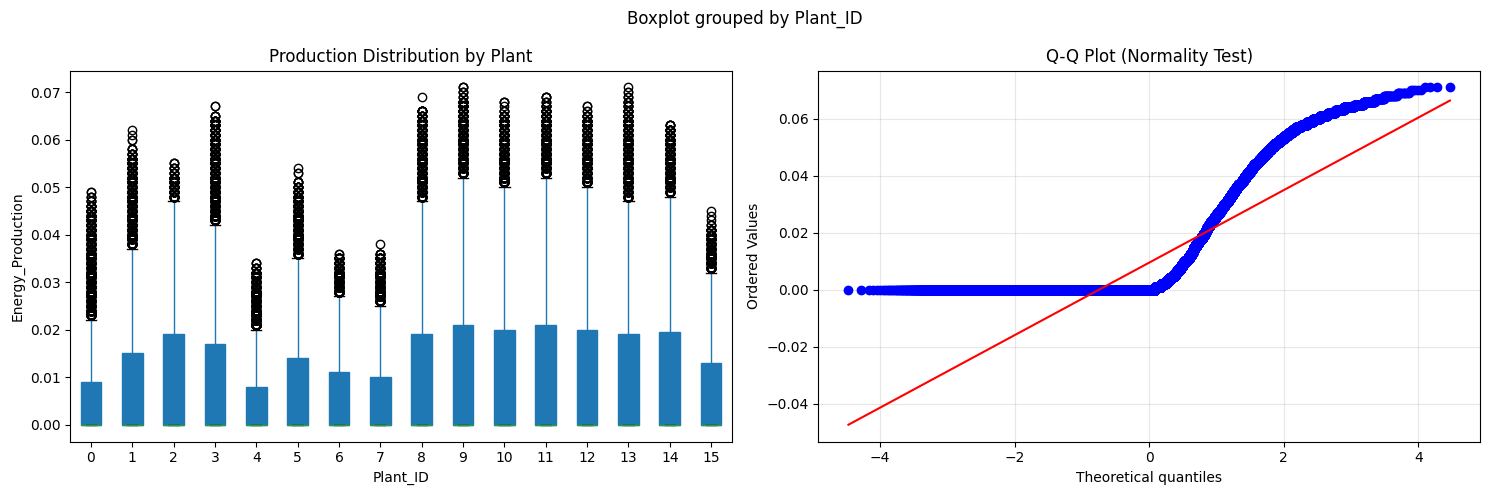


Energy_Production Statistics:
Mean: 0.01
Median: 0.00
Std: 0.02
Min: 0.00
Max: 0.07
Skewness: 1.66
Kurtosis: 1.74


In [ ]:
#Target variable (Energy production) distribution analysis
fig,axes = plt.subplots(1,2,figsize=(15,5))

#Boxplot by plant to compare distributions
train.boxplot(column="Energy_Production", by="Plant_ID", ax=axes[0],patch_artist=True, grid=False)
axes[0].set_title('Production Distribution by Plant')
axes[0].set_xlabel('Plant_ID')
axes[0].set_ylabel('Energy_Production')

#Q-Q plot to test for normality
#Reminder: points should follow the diagonal line if data is normally distributed
stats.probplot(train["Energy_Production"], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Normality Test)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# key statistics
print(f"\nEnergy_Production Statistics:")
print(f"Mean: {train['Energy_Production'].mean():.2f}")
print(f"Median: {train['Energy_Production'].median():.2f}")
print(f"Std: {train['Energy_Production'].std():.2f}")
print(f"Min: {train['Energy_Production'].min():.2f}")
print(f"Max: {train['Energy_Production'].max():.2f}")
print(f"Skewness: {train['Energy_Production'].skew():.2f}")  # Measures asymmetry
print(f"Kurtosis: {train['Energy_Production'].kurtosis():.2f}")  # Measures tail heaviness

Weather features identified: 12


['Temperature descriptor',
 'Comfort level',
 'Visibility',
 'Probability of precipitation for last hour',
 'Rainfall amount for last hour',
 'Dew point',
 'Temperature',
 'Wind direction',
 'Precipitation descriptor',
 'Sky descriptor',
 'Humidity',
 'Wind speed']

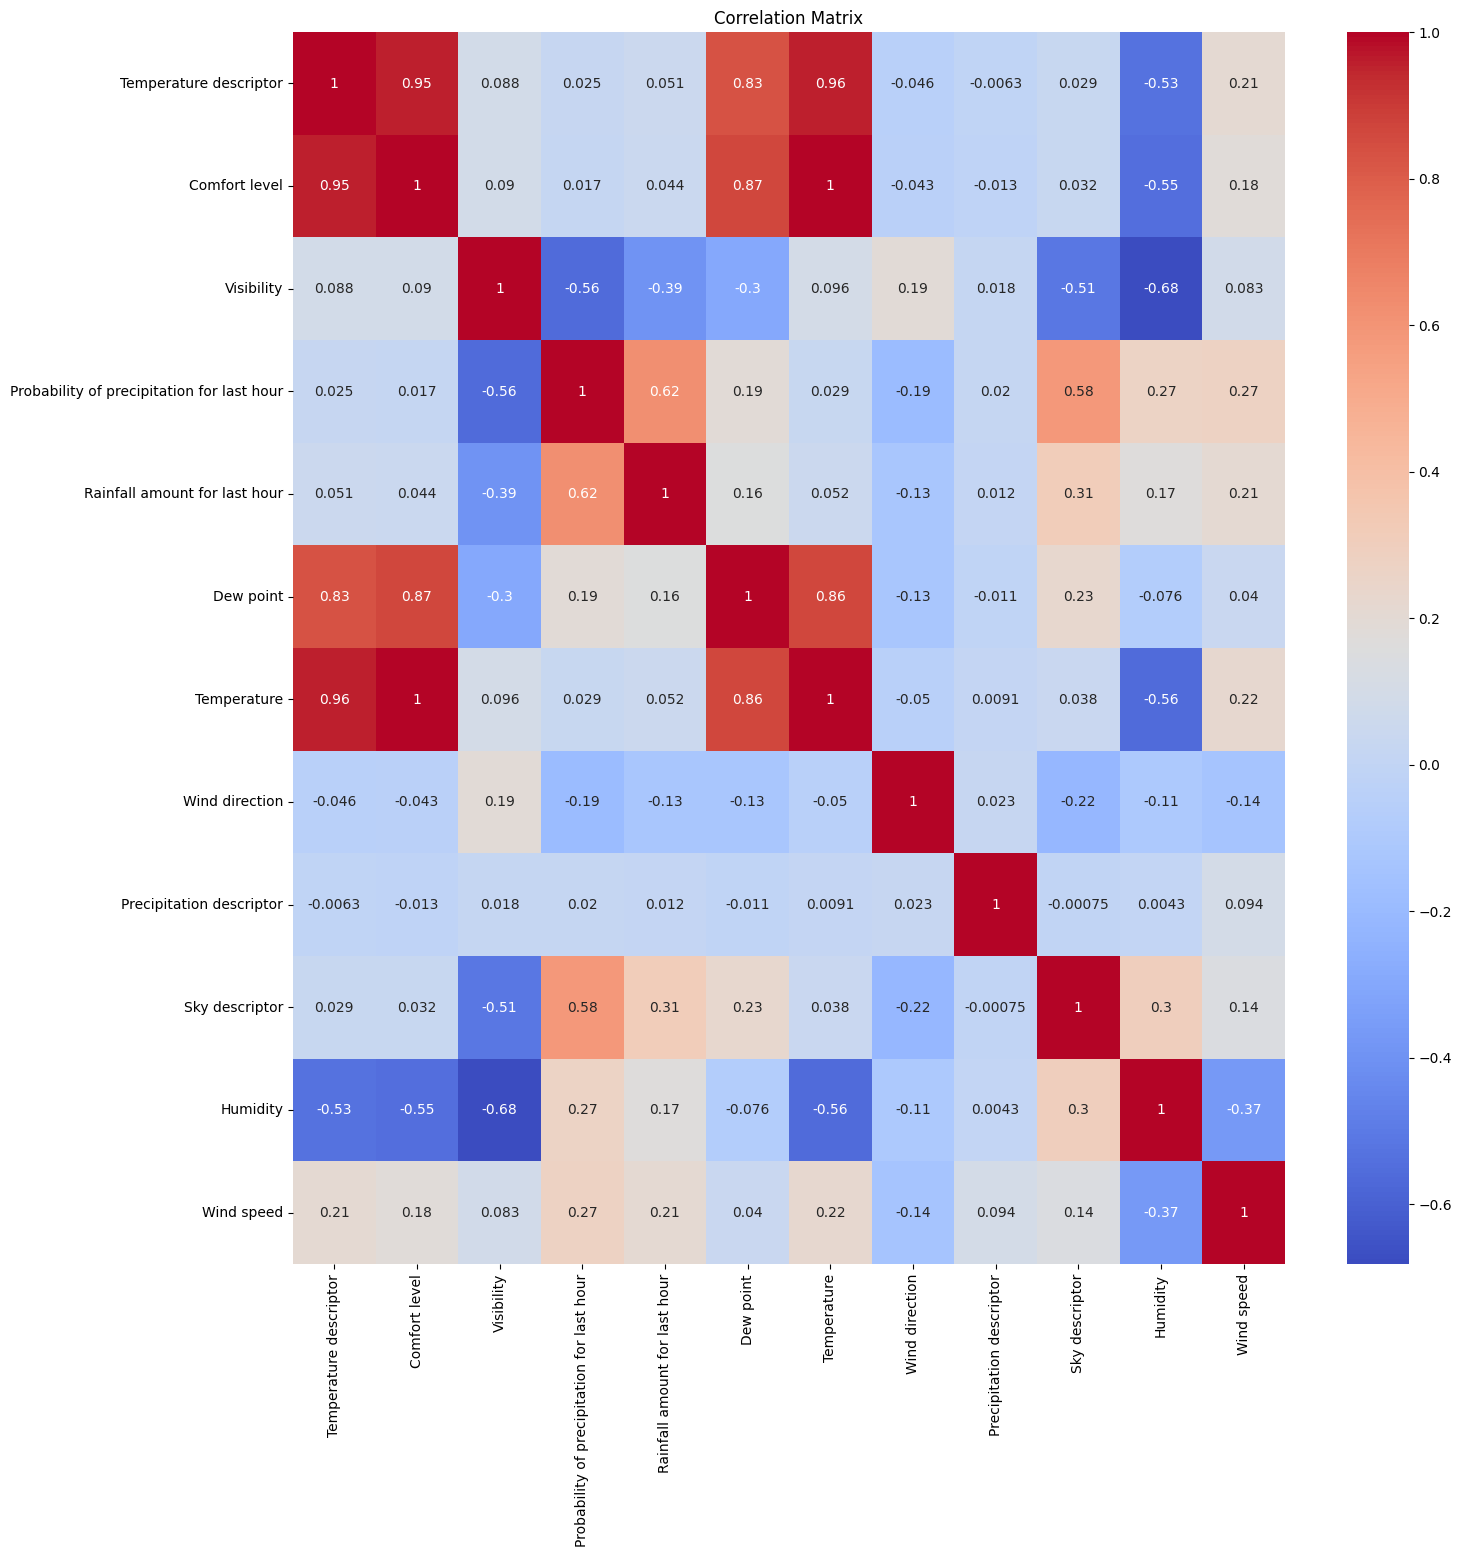

In [ ]:
#Correlations between weather variables
#Select only numerical weather features(excluding Plant_ID, Energy_Production and Benchmark)
weather_cols = train.select_dtypes(include=[np.number]).columns.tolist()
weather_cols=[col for col in weather_cols if col not in [plant_col,target_col,'Benchmark']]

print(f"Weather features identified: {len(weather_cols)}")
display(weather_cols)

#Correlation matrix
corr_matrix = train[weather_cols].corr()

#Visualisation of correlation matrix with heatmap
fig,ax=plt.subplots(figsize=(16,16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)
ax.set_title('Correlation Matrix')
plt.show()

#Identify highly correlated feature pairs with absolute correlation >0.8 as these pairs can cause multicolinearity issue in linear models
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1,len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i,j]) > 0.8:
          high_corr_pairs.append({"Feature_1":corr_matrix.columns[i],
                                  "Feature_2":corr_matrix.columns[j],
                                  "Correlation":corr_matrix.iloc[i,j]})

In [ ]:
#Correlation between weather features and target
target_corr=train[weather_cols+[target_col]].corr()[target_col].drop(target_col)
target_corr=target_corr.sort_values(ascending=False)
target_corr

,Energy_Production
Temperature,0.488400
Comfort level,0.481825
Temperature descriptor,0.467990
Visibility,0.395889
Wind speed,0.306496
Dew point,0.187473
Wind direction,0.040365
Precipitation descriptor,0.011819
Rainfall amount for last hour,-0.069988
Probability of precipitation for last hour,-0.115765


In [ ]:
#Production Variance across plants
variance_analysis=train.groupby("Plant_ID")["Energy_Production"].agg([
    ('Mean','mean'),
    ('Std', 'std'),
    ('Variance', 'var'),
    ('CV', lambda x: x.std() / x.mean() if x.mean() != 0 else 0),  # Coefficient of Variation
    ('Min', 'min'),
    ('Max', 'max'),
    ('Range', lambda x: x.max() - x.min())
]).round(2)
display(variance_analysis)

,Mean,Std,Variance,CV,Min,Max,Range
Plant_ID,,,,,,,
0,0.01,0.01,0.0,1.64,0.0,0.05,0.05
1,0.01,0.01,0.0,1.57,0.0,0.06,0.06
2,0.01,0.02,0.0,1.47,0.0,0.06,0.06
3,0.01,0.02,0.0,1.56,0.0,0.07,0.07
4,0.01,0.01,0.0,1.60,0.0,0.03,0.03
5,0.01,0.01,0.0,1.56,0.0,0.05,0.05
6,0.01,0.01,0.0,1.54,0.0,0.04,0.04
7,0.01,0.01,0.0,1.54,0.0,0.04,0.04
8,0.01,0.02,0.0,1.54,0.0,0.07,0.07


In [ ]:
#Outlier detection

#Quartiles and IQR
Q1=train["Energy_Production"].quantile(0.25)
Q3=train["Energy_Production"].quantile(0.75)
IQR=Q3-Q1

#Outlier boundaries
lower_bound=Q1-1.5*IQR
upper_bound=Q3+1.5*IQR

#Identify outliers (value outside the boundaries)
outliers=train[(train["Energy_Production"]<lower_bound) | (train["Energy_Production"]>upper_bound)]

# Display outlier statistics
print(f"\nOutlier Statistics (IQR Method):")
print(f"Q1 (25th percentile): {Q1:.2f}")
print(f"Q3 (75th percentile): {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")
print(f"Number of outliers: {len(outliers)} ({len(outliers)/len(train)*100:.2f}%)")

#Outliers by plant
outliers_by_plant=outliers.groupby("Plant_ID").size().sort_values(ascending=False)
print("Outliers by plant:")
display(outliers_by_plant)


Outlier Statistics (IQR Method):
Q1 (25th percentile): 0.00
Q3 (75th percentile): 0.01
IQR: 0.01
Lower bound: -0.02
Upper bound: 0.04
Number of outliers: 15374 (8.71%)
Outliers by plant:


,0
Plant_ID,
9,1793
11,1775
10,1613
13,1523
8,1512
12,1502
14,1490
3,1432
1,1043


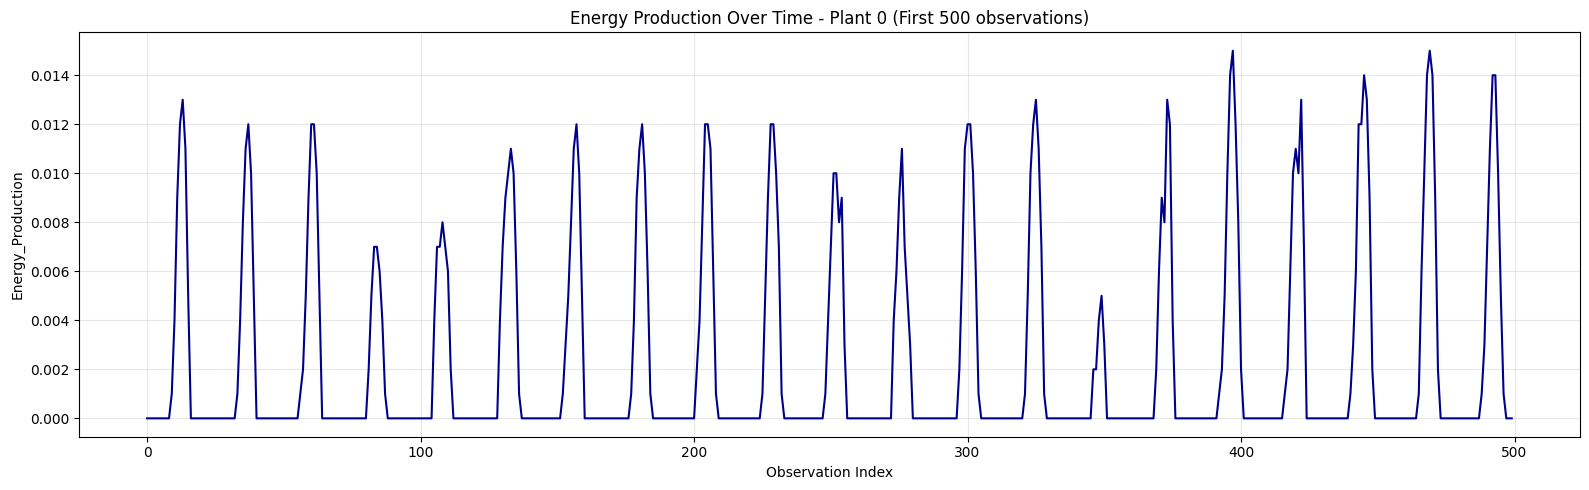

In [ ]:
#Time series analysis (to identify trend, seasonality, patterns)
sample_plant=train["Plant_ID"].unique()[0]
sample_data=train[train["Plant_ID"]==sample_plant].head(500)

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(sample_data.index, sample_data['Energy_Production'], linewidth=1.5, color='darkblue')
ax.set_title(f'Energy Production Over Time - Plant {sample_plant} (First 500 observations)')
ax.set_xlabel('Observation Index')
ax.set_ylabel('Energy_Production')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2. FEATURE ENGINEERING

In [ ]:
#Cyclical features
def cyclical_features(df):
  """
  Creates cyclical features for time-based.
  Uses sin/cos to encode hour, day, month.
  """
  df=df.copy()

  df["hour"]=df[time_col].dt.hour
  df["day"]=df[time_col].dt.day
  df["month"]=df[time_col].dt.month
  df["year"]=df[time_col].dt.year
  df["day_of_week"]=df[time_col].dt.dayofweek
  df['day_of_year'] = df[time_col].dt.dayofyear

  #For hour of a day (24h)
  df['hour_sin'] = np.sin(2 * np.pi*df['hour']/24)
  df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)

  #Day of year(1-365)
  df['day_sin']=np.sin(2*np.pi*df['day_of_year']/365)
  df['day_cos']=np.cos(2*np.pi*df['day_of_year']/365)

  #Month of year (1-12)
  df['month_sin']=np.sin(2*np.pi*df['month']/12)
  df['month_cos']=np.cos(2*np.pi*df['month']/12)

  #Day of week (0-6)
  df['day_of_week_sin']=np.sin(2*np.pi*df['day_of_week']/7)
  df['day_of_week_cos']=np.cos(2*np.pi*df['day_of_week']/7)

  return df

  train=cyclical_features(train)
  test=cyclical_features(test)


In [ ]:
#Lag and rolling features (for panel data safety)
def lag_features(df, lags=[1,2,3,24,48,168]):
  df_copy=df.copy()
  for lag in lags:
    df_copy[f'Energy_Production_lag_{lag}'] = df_copy.groupby("Plant_ID")["Energy_Production"].shift(lag)
  return df_copy

def rolling_features(df, windows=[3,6,12,24]):
  df_copy=df.copy()

  for window in windows:
        # Rolling mean
        df_copy[f"Energy_Production_rolling_mean_{window}"] = df_copy.groupby("Plant_ID")["Energy_Production"].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean())

        # Rolling standard deviation
        df_copy[f"Energy_Production_rolling_std_{window}"] = df_copy.groupby("Plant_ID")["Energy_Production"].transform(
            lambda x: x.rolling(window=window, min_periods=1).std().fillna(0))

        # Rolling min and max
        df_copy[f"Energy_Production_rolling_min_{window}"] = df_copy.groupby("Plant_ID")["Energy_Production"].transform(
            lambda x: x.rolling(window=window, min_periods=1).min())
        df_copy[f"Energy_Production_rolling_max_{window}"] = df_copy.groupby("Plant_ID")["Energy_Production"].transform(
            lambda x: x.rolling(window=window, min_periods=1).max())

  return df_copy

train=lag_features(train)
train=rolling_features(train)
test=lag_features(test)
test=rolling_features(test)

new_features=[col for col in train.columns if col not in ["Plant_ID","UTC Time", "Energy_Production", 'Day-Night']+weather_cols]
print(f"New features created:{len(new_features)}")


New features created:23


In [ ]:
#Dimensionality reduction (PCA)
weather_features=[col for col in weather_cols if not col.startswith("Energy_Production_")]

print(f"Number of weather features for PCA: {len(weather_features)}")

#apply PCA
scaler=StandardScaler()
n_components=min(15,len(weather_features))

train_scaled=scaler.fit_transform(train[weather_features])
test_scaled=scaler.transform(test[weather_features])

pca=PCA(n_components=n_components)
train_pca=pca.fit_transform(train_scaled)
test_pca=pca.fit_transform(test_scaled)

train_pca_df=pd.DataFrame(
    train_pca,
    columns=[f"PCA_{i+1}" for i in range(n_components)],
    index=train.index
)

test_pca_df=pd.DataFrame(
    test_pca,
    columns=[f"PCA_{i+1}" for i in range(n_components)],
    index=test.index
)

original_features=[col for col in train.columns if col not in [target_col,"Benchmark",time_col]]

non_weather_features=[col for col in train.columns if col not in weather_features +[target_col,"Benchmark",time_col] ]

train_with_pca = pd.concat([
    train[non_weather_features],
    train_pca_df
], axis=1)

test_with_pca = pd.concat([
    test[non_weather_features],
    test_pca_df
], axis=1)


Number of weather features for PCA: 12


In [ ]:
#time series split
#val_size=0.3
def time_series_split(df):
  df=df.sort_index()

  n_splits=int(len(df)*(1-0.3))

  train_df=df.iloc[:n_splits].copy()
  val_df=df.iloc[n_splits:].copy()

  train_features=train_df.drop(columns=["Energy_Production"])
  train_target=train_df["Energy_Production"]

  val_features=val_df.drop(columns=["Energy_Production"])
  val_target=val_df["Energy_Production"]

  return train_features, train_target, val_features, val_target

X_train_orig,y_train_orig,X_val_orig,y_val_orig=time_series_split(pd.concat([train[original_features],train[target_col]],axis=1))
X_train_pca,y_train_pca,X_val_pca,y_val_pca=time_series_split(pd.concat([train_with_pca,train[target_col]],axis=1))

print(f"Training set shape: {X_train_orig.shape}")
print(f"Validation set shape: {X_val_orig.shape}")

Training set shape: (123553, 36)
Validation set shape: (52952, 36)


In [ ]:
#Function to train and evaluate models
def train_and_evaluate(X_train, y_train, X_val, y_val, models_dict):
  results = {}
  for model_name, model in models_dict.items():
    model.fit(X_train,y_train)

    train_preds=model.predict(X_train)
    val_preds=model.predict(X_val)

    #metrics
    train_rmse=np.sqrt(mean_squared_error(y_train,train_preds))
    val_rmse=np.sqrt(mean_squared_error(y_val,val_preds))
    train_r2=r2_score(y_train,train_preds)
    val_r2=r2_score(y_val,val_preds)

    results[model_name] = {
        'Train_RMSE': train_rmse,
        'Val_RMSE': val_rmse,
        'Train_R2': train_r2,
        'Val_R2': val_r2,
        'Val_Preds': val_preds
    }
  return results

In [ ]:
#Models to train
models = {
    'Ridge': Ridge(alpha=1),
    'Lasso': Lasso(alpha=0.1),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42)
}

original_results=train_and_evaluate(X_train_orig,y_train_orig,X_val_orig,y_val_orig,models)
pca_results=train_and_evaluate(X_train_pca,y_train_pca,X_val_pca,y_val_pca,models)



ValueError: could not convert string to float: 'N'

In [ ]:
train_with_pca

In [ ]:
train[original_features]